# Trabalho de casa 01: Método dos vizinhos mais próximos ($k$-NN)

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'.

## Exercícios computacionais

**Exercício 1.** O código abaixo carrega o dataset MNIST, que consiste em imagens de dígitos entre $0$ e $9$. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 5) e reporte a acurácia para cada valor de $k$. Lembre que a acurácia é o percentual de amostras classificadas corretamente. Notavelmente, as entradas do MNIST tem dimensão relativamente alta (64). Plote uma imagem com a variância amostral dos pixels das imagens e comente. Também mostre as imagens classificadas de maneira errônea e comente.

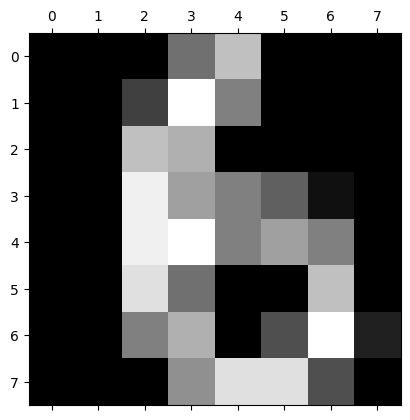

In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits, make_moons
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)

@dataclass
class Dataset:
    features_train: np.ndarray 
    features_test: np.ndarray  
    labels_train: np.ndarray   
    labels_test: np.ndarray

# Import dataset and separate train/test subsets
mnist = Dataset(*train_test_split(
    *load_digits(return_X_y=True),
    random_state=SEED,
))

# Notice that, in the MNIST dataset, the images are already flattened, i.e., are
# represented as 64-dimensional vectors, not as 8 by 8 matrices.

# To plot one of them, you should reshape it back into (8, 8)
plt.matshow(mnist.features_test[0].reshape(8, 8))
plt.gray()
plt.show()

Uma implementação de **kNN**:

In [2]:
class kNN():
    def __init__(self, k):
        self.k = k

    def fit(self, features, labels):
        self.features = features
        self.labels = labels
        
    def predict(self, features):
        predictions = []
        for feature in features:
            distance = np.sqrt(np.sum((feature - self.features)**2, axis=1))
            nearest = np.argsort(distance)[:self.k] # encontra os pontos de treino mais próximos
            k_nearest_labels = [self.labels[label] for label in nearest] # encontra as classes dos pontos de treino mais próximos
            prediction = (np.bincount(k_nearest_labels)).argmax() # retorna a classe mais frequente entre os k pontos de treino mais próximos
            predictions.append(prediction)
        return np.array(predictions)
    
    def accuracy(self, y_true, y_pred):
        acc = np.sum(y_true == y_pred) / len(y_true)
        return acc

**Acurácia** dos valores de $k$ no intervalo [1, 5]:

In [3]:
ks = [1, 2, 3, 4, 5]

results_mnist = {}

for k in ks:
    kNN_mnist = kNN(k)
    kNN_mnist.fit(mnist.features_train, mnist.labels_train) # dou os valores e as classes
    prediction = kNN_mnist.predict(mnist.features_test) # dou os valores de treino para ele retornar as classes
    accuracy = kNN_mnist.accuracy(mnist.labels_test, prediction)
    results_mnist[k] = prediction
    print(f'Accuracy for k = {k}: {accuracy}')

Accuracy for k = 1: 0.9822222222222222
Accuracy for k = 2: 0.9844444444444445
Accuracy for k = 3: 0.9866666666666667
Accuracy for k = 4: 0.9866666666666667
Accuracy for k = 5: 0.9933333333333333


Plotagem da imagem com a **variância amostral** dos pixels das imagens:

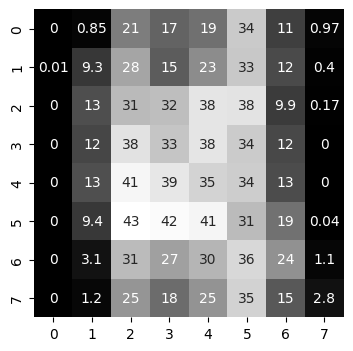

In [4]:
# armazeno juntos os pixels de uma mesma posição em imagens diferentes e calculo a variância deles
variances = []

for i in range(64):
    pixels = []
    pixels.append(mnist.features_test[:, i])
    variances.append(np.var(pixels))

variances = np.array(variances).round(2)

plt.figure(figsize=(4, 4))
sns.heatmap(variances.reshape(8, 8), 
            cmap='gray', 
            annot = True,
            cbar=False)
plt.show()

Esse é um resultado natural, já que as laterais tanto da esquerda quanto da direita, onde normalmente não há partes dos números, estão mais escuras, isto é, variância menor. Na mesma linha, a parte mais central do *heatmap* está mais claro, indicando variâncias mais altas - é claro, há uma variedade de números sendo apresentados nessa região, o que faz com que a variância seja maior.

Imagens classificadas de maneira **errônea**:

For k = 1, the missclassified images were [ 52 118 133 159 204 222 249 431]
For k = 2, the missclassified images were [ 52 133 144 159 204 222 249]
For k = 3, the missclassified images were [ 52 133 144 159 204 249]
For k = 4, the missclassified images were [ 52 144 159 204 222 249]
For k = 5, the missclassified images were [ 71 159 249]

In general, the missclassified images were [133, 71, 204, 431, 144, 52, 118, 249, 222, 159], so let's plot them.


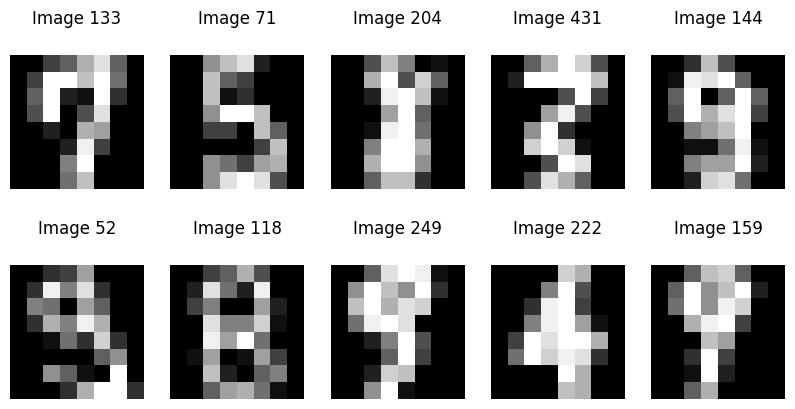

In [5]:
bad_classification = {}

for k in ks:
    bad_classification[k] = np.where(mnist.labels_test != results_mnist[k])[0]
    print(f'For k = {k}, the missclassified images were {bad_classification[k]}')

wrong_ones = list(set(np.concatenate([bad_classification[k] for k in ks])))

print('')
print(f'In general, the missclassified images were {wrong_ones}, so let\'s plot them.')

f = plt.figure(figsize=(10, 5))
gs = f.add_gridspec(2, int(len(wrong_ones)/2)) # 2 linhas e 5 colunas, pq len(all_wrong) = 10 (5 imagens por linha)

for i in range(len(wrong_ones)): 
    ax = f.add_subplot(gs[i])
    ax.matshow(mnist.features_test[wrong_ones[i]].reshape(8, 8)) # pega, no conjunto de teste, a imagem que foi classificada errôneamente. ex: all_wrong[0] = 133
    ax.set_title(f'Image {wrong_ones[i]}')
    ax.axis('off')

plt.show()

Como vimos quando foram apresentadas as acurácias do modelo k-NN para cada k escolhido, o k de maior acurácia foi o $k = 5$. Em particular, 3 imagens foram classificadas errôneamente neste caso, e o plot de suas imagens mostra que, de fato, são aquelas com mais "defeitos" (71, 159, 249). Além disso, no $k = 5$, o modelo foi capaz de classificar corretamente imagens que também são bastante confusas, como é o caso da 52 - inclusive, classificada incorretamente para todos os outros $k$.

**Exercício 02.** O código abaixo carrega o dataset "two moons", que consiste de amostras bidimensionais divididas em duas classes. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 10). Plote a superfície de decisão para cada valor de $k$. Como $k$ influencia na suavidade dessas superfícies?

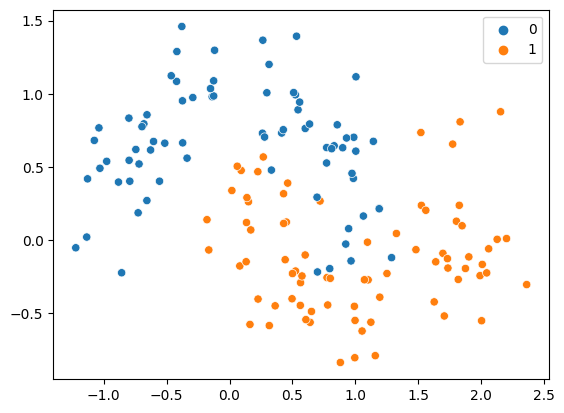

In [6]:
# Import dataset and separate train/test subsets
moon = Dataset(*train_test_split(
    *make_moons(n_samples=200, shuffle=True, noise=0.25, random_state=SEED),
    random_state=SEED,
))

# Let's also plot the moon dataset, for you to take a look at it.
sns.scatterplot(
    x=moon.features_train[:, 0],
    y=moon.features_train[:, 1],
    hue=moon.labels_train,
)
plt.show()

Aplicação do kNN ao conjunto:

In [7]:
k_moon = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

results_moon = {}

for k in k_moon:
    kNN_moons = kNN(k)
    kNN_moons.fit(moon.features_train, moon.labels_train) # dou os valores e as classes
    results_moon[k] = kNN_moons.predict(moon.features_test) # dou os valores de treino para ele retornar as classes
    accuracy = kNN_moons.accuracy(moon.labels_test, results_moon[k])
    print(f'Accuracy for k = {k}: {accuracy}') # não pediu, mas só pq eu queria ver

Accuracy for k = 1: 0.94
Accuracy for k = 2: 0.92
Accuracy for k = 3: 0.92
Accuracy for k = 4: 0.92
Accuracy for k = 5: 0.92
Accuracy for k = 6: 0.9
Accuracy for k = 7: 0.94
Accuracy for k = 8: 0.92
Accuracy for k = 9: 0.94
Accuracy for k = 10: 0.94


Plots da **superfície de decisão** para cada k:

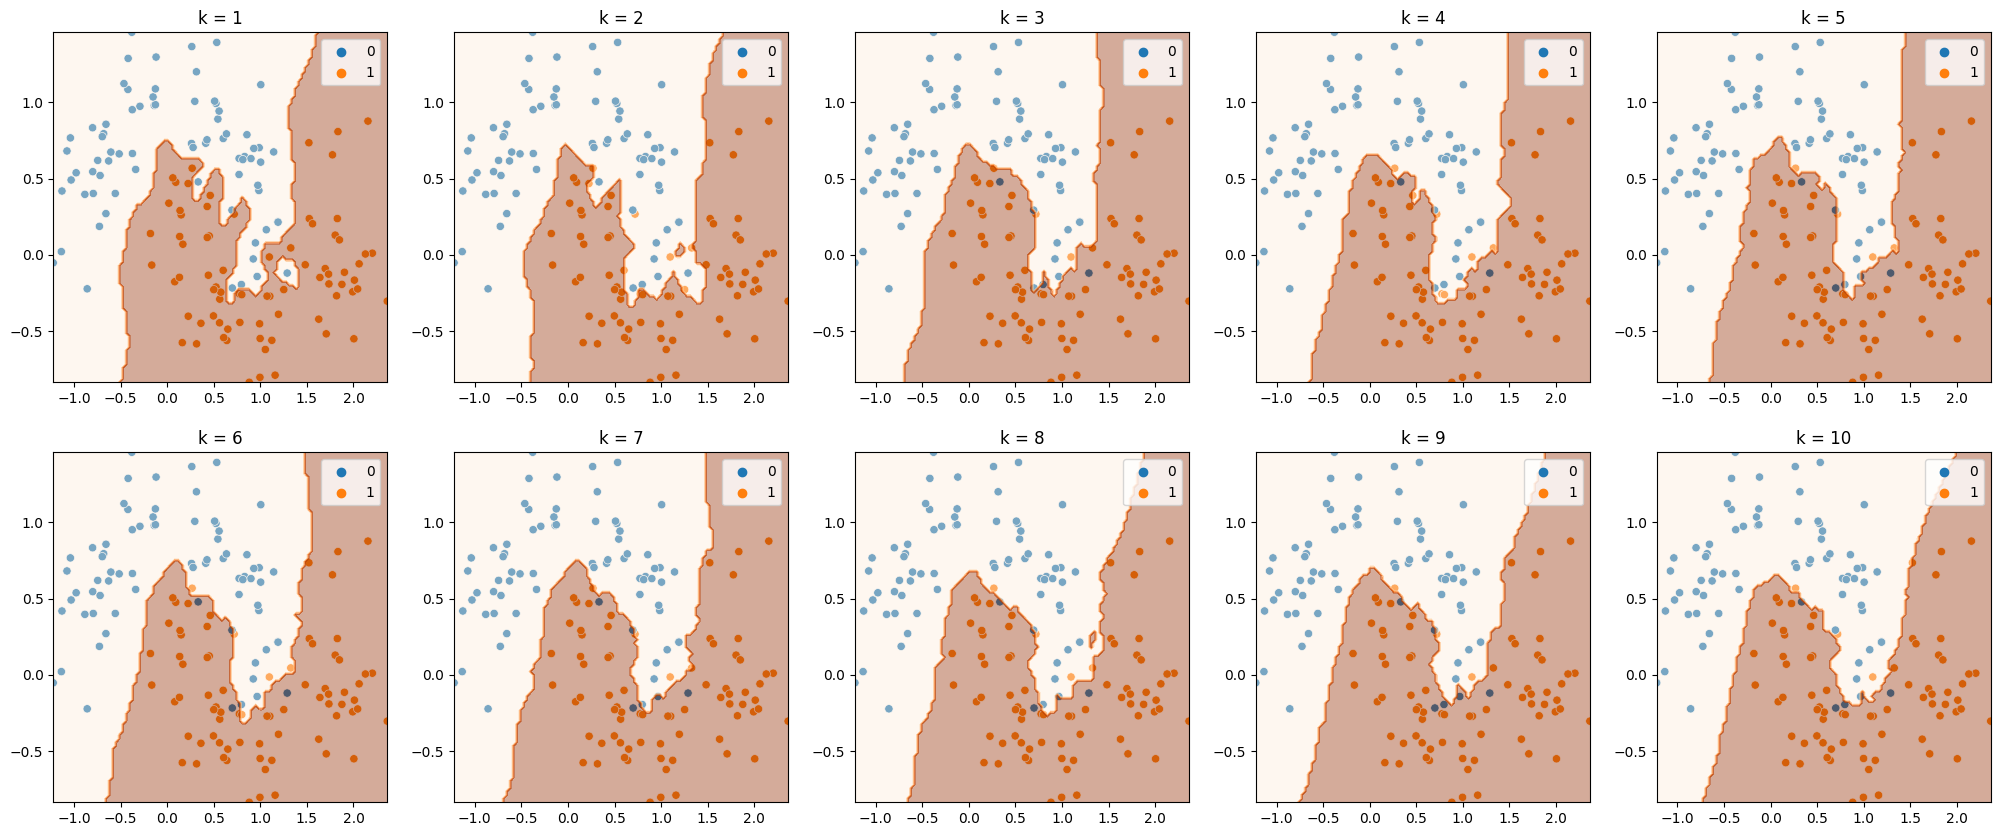

In [8]:
xmax, xmin = moon.features_train[:, 0].max(), moon.features_train[:, 0].min()
ymax, ymin = moon.features_train[:, 1].max(), moon.features_train[:, 1].min()

x = np.linspace(xmin, xmax, 100)
y = np.linspace(ymin, ymax, 100)

xx, yy = np.meshgrid(x, y)

grid = np.c_[xx.ravel(), yy.ravel()]

f = plt.figure(figsize=(25, 10))

for k in k_moon:

    kNN_dec_boundary = kNN(k)
    kNN_dec_boundary.fit(moon.features_train, moon.labels_train)
    prediction = kNN_dec_boundary.predict(grid)

    f.add_subplot(2, 5, k)
    sns.scatterplot(x=moon.features_train[:, 0], y=moon.features_train[:, 1], hue=moon.labels_train)
    plt.contourf(xx, yy, prediction.reshape(xx.shape), alpha=0.4, cmap='Oranges')
    plt.title(f'k = {k}')

plt.show()

O plot de todas as superfícies de decisão permite avaliar que, à medida que k aumenta, as curvas ficam mais suaves. Note, por exemplo, que para $k=1$, o modelo criou até mesmo uma "ilha" para um dos pontos, já que calcula pelo mais próximo. Isso vai se tornando cada vez menos comum conforme aumenta o número k.

# Exercícios de "papel e caneta"

**Exercício 1.** Como mencionado na nota de aula, é comum *normalizar* os dados antes de utilizar algoritmos de ML. Seja $\mathbf{x} \in \mathcal{X}$ um ponto arbitrário do nosso conjunto de dados (antes de normalização). Deixe também que $\mathcal{V}_k(\mathbf{x})$ seja o conjunto dos $k$ vizinhos mais próximos de $\mathbf{x}$ dentre nossas observações. É possível que $\mathcal{V}_k(\mathbf{x})$ mude caso normalizemos os dados? Prove.

Veremos, a partir de um exemplo, que a normalização dos dados pode alterar a classificação do k-NN. A normalização foi feita a partir da distância euclidiana e utilizaremos no processo um $k = 3$.

Suponha o seguinte *dataset*, em que o ponto $\mathbf{x} \in \mathcal{X}$ é a última linha, com $\texttt{Feature 1} = 9$ e $\texttt{Feature 2} = 350$. Já foi calculada a distância entre o ponto $\mathbf{x}$ e os outros pontos:

| Feature 1 | Feature 2 | Class | Distance to $\mathbf{x}$ |
|-----------|-----------|-------|---------------|
| 1         | 200       | A     | 150.213182    |
| 3         | 400       | A     | 50.358713     |
| 5         | 600       | B     | 250.031998    |
| 7         | 800       | B     | 450.004444    |
| 2         | 1000      | B     | 650.037691    |
| 9         | 350       | A     | 0.000000      |

Utilizando $k = 3$, a classe do ponto será A. Isso, no entanto, muda com o *dataset* normalizado. Vejamos:

| Feature 1 | Feature 2 | Distance to $\mathbf{x}$ |
|-----------|-----------|---------------|
| -1.135550 | -1.191689 | 2.643046      |
| -0.486664 | -0.526560 | 1.953746      |
| 0.162221  | 0.138568  | 1.541251      |
| 0.811107  | 0.803697  | 1.631160      |
| -0.811107 | 1.468826  | 3.135396      |
| 1.459993  | -0.692842 | 0.000000      |

Note, agora, que a distância calculada faz com que o ponto em questão seja classificado na classe B.

**Exercício 2.** Suponha que estamos usando $k$-NN equipado com distância Mahalanobis $d_M$ (veja Eq. 3.5 das notas de aula). Suponha ainda que $\Sigma$ é a matrix de covariância real dos dados (i.e., do vetor aleatório $\mathbf{x} \sim \mathbb{P}_\mathbf{x}$), ao invés de uma estimativa baseada em amostras. Existe uma transformação $g$ tal que $d_M(a, b) = \|g(a) - g(b) \|_2$? Mostre a transformação e derive a matriz de covariância de $z = g(\mathbf{x})$. 

A transformação existe. Supondo que $\sum$, a matriz de covariância, é definida positiva, e utilizando a decomposição espectral, teremos que:

$$d_M(x, y) = \sqrt{(x-y)^T \Sigma^{-1} (x-y)} = $$
$$= \sqrt{(x-y)^T (Q \lambda Q^T)^{-1} (x-y)}$$
$$= \sqrt{(x-y)^T (Q \sqrt{\lambda} \sqrt{\lambda} Q^T)^{-1} (x-y)}$$

Observe que precisamos manipular a expressão $(Q \sqrt{\lambda} \sqrt{\lambda} Q^T)^{-1}$ para continuar. Pelas propriedades das matrizes Q no que diz respeito a inversas e transpostas, podemos obter:

$$(Q \sqrt{\lambda} \sqrt{\lambda} Q^T)^{-1} = (\sqrt\lambda Q^T)^{-1}(Q \sqrt\lambda)^{-1} = Q (\sqrt\lambda)^{-1} (\sqrt\lambda)^{-1} Q^{-1}$$

Voltando à nossa expressão original, temos:

$$\sqrt{(x-y)^T Q (\sqrt\lambda)^{-1} (\sqrt\lambda)^{-1} Q^{-1} (x-y)}$$
$$= \sqrt{((Q (\sqrt\lambda)^{-1})^T (x-y))^T(\sqrt\lambda)^{-1} Q^T (x-y)}$$
$$= \sqrt{(((\sqrt\lambda)^{-1} Q^T) (x-y))^T(\sqrt\lambda)^{-1} Q^T (x-y)}$$
$$= \sqrt{((\sqrt{\lambda})^{-1} Q^T x - (\sqrt{\lambda})^{-1} Q^T y)^T((\sqrt{\lambda})^{-1} Q^T x - (\sqrt{\lambda})^{-1} Q^T y)}$$

Observe que a expressão acima possui o mesmo formato geral de $||u||_2 = u^Tu$, isto é, a própria norma euclidiana. Com isso, temos:

$$|| (\sqrt\lambda)^{-1} Q^T x - (\sqrt\lambda)^{-1} Q^T y||_2 = || g(x) - g(y) ||_2$$

A transformação, portanto, é justamente $g(a) = (\sqrt\lambda)^{-1} Q^T a$.

Agora, para derivar a matriz de covariância, precisamos de sua fórmula geral, qual seja $\Sigma = E \left[ (X - E[X]) (X - E[X])^T\right]$. Aplicando a transformação g ao X, poderemos derivá-la. Segue:

$$ E \left[ (g(x) - E[g(x)])(g(x) - E[g(x)])^T  \right] $$

Substituímos $g(x)$ pela sua fórmula correspondente:

$$ = E \left[ ((\sqrt{\lambda})^{-1} Q^T x - E[(\sqrt{\lambda})^{-1} Q^T x])((\sqrt{\lambda})^{-1} Q^T x - E[(\sqrt{\lambda})^{-1} Q^T x])^T                                    \right]$$

Como o valor esperado diz respeito somente a $x$, fazemos:

$$ = E \left[ ((\sqrt{\lambda})^{-1} Q^T x - (\sqrt{\lambda})^{-1} Q^T E[x])((\sqrt{\lambda})^{-1} Q^T x - (\sqrt{\lambda})^{-1} Q^T E[x])^T               \right] $$

Aplicamos a transposição, obtendo:

$$ = E \left[ ((\sqrt{\lambda})^{-1} Q^T x - (\sqrt{\lambda})^{-1} Q^T E[x]) ( x^T Q ((\sqrt{\lambda})^{-1})^T - E[x]^T Q ((\sqrt{\lambda})^{-1})^T)               \right] $$

Aplicamos a distributiva, obtendo a expressão:

$$ E \left[ (\sqrt{\lambda})^{-1}Q^T x x^T Q ((\sqrt{\lambda})^{-1})^T - (\sqrt{\lambda})^{-1} Q^T x E[x]^T Q ((\sqrt{\lambda})^{-1})^T - (\sqrt{\lambda})^{-1} Q^T E[x] x^T Q ((\sqrt{\lambda})^{-1})^T + (\sqrt{\lambda})^{-1} Q^T E[x] E[x]^T Q ((\sqrt{\lambda})^{-1})^T       \right]  $$

Evidenciando os fatores que não estão em função de $x$, temos:

$$ = (\sqrt{\lambda})^{-1} Q^T (E[xx^T - xE[x^T] - E[x]x^T] + E[x]E[x]^T)Q ((\sqrt{\lambda})^{-1})^T$$

$$= (\sqrt{\lambda})^{-1} Q^T (E[(x - E[x])(x^T - E[x^T])]) Q ((\sqrt{\lambda})^{-1})^T$$

$$= (\sqrt{\lambda})^{-1} Q^T (E[(x - E[x])(x - E[x])^T]) Q ((\sqrt{\lambda})^{-1})^T$$

A composição dos valores esperados em questão são, na prática, a matriz de covariância:

$$= (\sqrt{\lambda})^{-1} Q^T \Sigma ((\sqrt{\lambda})^{-1})^T$$
$$= (\sqrt{\lambda})^{-1} Q^T Q \lambda Q^T Q ((\sqrt{\lambda})^{-1})^T$$

Como $Q^TQ = I$, temos:

$$= (\sqrt{\lambda})^{-1} \lambda (\sqrt{\lambda})^{-1} = I$$

Isto é, obtemos a matriz identidade.